# Setup

In [26]:
import sqlite3
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine import imputation

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [27]:
# Importando os dados

path = r'C:\Users\franc\Data Science\Notebooks\o-list\data\olist.db'
with sqlite3.connect(path) as conn:
    query = 'SELECT * FROM abt_olist_churn'
    df = pd.read_sql_query(query, conn)

In [28]:
df.head()

,dtReference,idVendedor,qtdPedidos,qtdDiasComPedidos,qtItens,ticketMedio,avgValorProduto,maxValorProduto,minValorProduto,avgProdutoPorPedido,lifeTimeValue,qtdDiasPrimeiraVenda,qtdRecenciaVenda,avgIntervaloVendas,avgNota,minNota,maxNota,pctAvaliacao,qtdUFsDistintos,pctPedidoAC,pctPedidoAL,pctPedidoAM,pctPedidoAP,pctPedidoBA,pctPedidoCE,pctPedidoDF,pctPedidoES,pctPedidoGO,pctPedidoMA,pctPedidoMG,pctPedidoMS,pctPedidoMT,pctPedidoPA,pctPedidoPB,pctPedidoPE,pctPedidoPI,pctPedidoPR,pctPedidoRJ,pctPedidoRN,pctPedidoRO,pctPedidoRR,pctPedidoRS,pctPedidoSC,pctPedidoSE,pctPedidoSP,pctPedidoTO,pctPedidoCancelado,pctPedidosAtrasados,avgFrete,maxFrete,minFrete,avgDifDiasEntregaAprovado,avgDifDiasEntregaEstimativa,qtde_credit_card_pedido,qtde_boleto_pedido,qtde_debit_card_pedido,qtde_voucher_pedido,valor_credit_card_pedido,valor_boleto_pedido,valor_debit_card_pedido,valor_voucher_pedido,pct_qtd_credit_card_pedido,pct_qtd_boleto_pedido,pct_qtd_debit_card_pedido,pct_qtd_voucher_pedido,pct_valor_credit_card_pedido,pct_valor_boleto_pedido,pct_valor_debit_card_pedido,pct_valor_voucher_pedido,avgQtdParcelas,maxQtdParcelas,minQtdParcelas,qtdCategoriasVendedor,avgFotosVendedor,avgPesoGramas,avgVolProduto,minVolProduto,maxVolProduto,pctCategoria_cama_mesa_banho,pctCategoria_beleza_saude,pctCategoria_esporte_lazer,pctCategoria_informatica_acessorios,pctCategoria_moveis_decoracao,pctCategoria_utilidades_domesticas,pctCategoria_relogios_presentes,pctCategoria_telefonia,pctCategoria_automotivo,pctCategoria_brinquedos,pctCategoria_cool_stuff,pctCategoria_ferramentas_jardim,pctCategoria_perfumaria,pctCategoria_bebes,pctCategoria_eletronico,pctSalesOnTop15Category,flChurn
0,2017-10-01,0015a82c2db000af6aaaf3ae2ecb0532,1,1,1,895.000000,895.000000,895.000000,895.000000,1,895.000000,5.0,5.0,NaN,5.000000,5.0,5.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,1.000000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.066481,-23.000000,1,0,0,0,916.020020,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,10.000000,10.0,10.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2017-11-01,0015a82c2db000af6aaaf3ae2ecb0532,3,3,1,895.000000,895.000000,895.000000,895.000000,1,2685.000000,36.0,14.0,11.000000,3.666667,1.0,5.0,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.497693,-16.333333,3,0,0,0,2748.060059,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,7.333333,10.0,4.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2017-12-01,0015a82c2db000af6aaaf3ae2ecb0532,3,3,1,895.000000,895.000000,895.000000,895.000000,1,2685.000000,66.0,44.0,11.000000,3.666667,1.0,5.0,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.497693,-16.333333,3,0,0,0,2748.060059,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,7.333333,10.0,4.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2017-03-01,001cca7ae9ae17fb1caed9dfb1094831,5,4,1,219.780003,99.900002,99.900002,99.900002,2,1098.900017,25.0,2.0,7.666667,4.200000,2.0,5.0,1.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.400,0.0,0.0,0.0,0.0,0.000000,0.2000,0.0,0.0,0.0,0.2000,0.0000,0.0,0.200,0.0000,0.0,0.0000,39.299999,74.349999,16.40,15.088567,-18.200000,4,1,0,0,1053.299988,242.100006,0.0,0.000000,0.800000,0.200000,0.0,0.000000,0.813108,0.186892,0.0,0.0000,7.000000,10.0,4.0,1,4.0,8875.000000,24080.000000,24080.0,24080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,2017-04-01,001cca7ae9ae17fb

# Exploratory Data Analysis

Primeiro, vamos olhar se temos algum missing no nosso dataset.

In [29]:
df.isnull().sum().sort_values(ascending=False).head(15)

avgIntervaloVendas             1408
avgQtdParcelas                  385
maxQtdParcelas                  385
minQtdParcelas                  385
pctPedidosAtrasados             176
maxNota                           9
minNota                           9
avgNota                           9
minVolProduto                     1
maxVolProduto                     1
avgVolProduto                     1
avgDifDiasEntregaAprovado         1
valor_voucher_pedido              0
pct_valor_debit_card_pedido       0
pct_valor_boleto_pedido           0
dtype: int64

Temos alguns valores missing! Vamos lidar com eles após realizar a separação dos dados em treino e teste, para evitar vazamento de dados.

Vamos olhar os tipos de dados que temos!

In [30]:
df.dtypes.value_counts()

float64    82
int64      11
object      2
dtype: int64

In [31]:
df.dtypes[df.dtypes == 'object']

dtReference    object
idVendedor     object
dtype: object

Apenas temos duas variáveis categóricas, que são 'dtReference' e 'idVendedor'. Porém não precisamos nos preocupar com essas variáveis, visto que serão removidas do nosso vetor X.

Vamos olhar a distribuição da nossa variável target.

Churn proportion: 0.3237493417588204


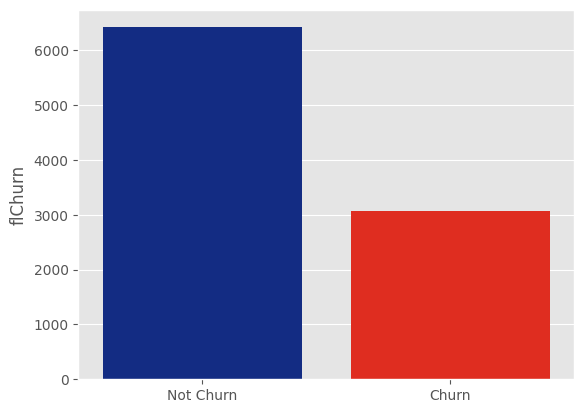

In [92]:
palette = ["#002296", "#ff1100"]
sns.set_palette(palette)
sns.barplot(x=['Not Churn', 'Churn'], y=df['flChurn'].value_counts());
churn_proportion = df['flChurn'].mean()

print('Churn proportion:', churn_proportion);

Note que nossa target é levemente desbalanceada. Por conta disso, não precisamos usar nenhuma tecnica de balanceamento.

Vamos olhar as estatísticas dos nossos dados.

In [33]:
df.describe()

,qtdPedidos,qtdDiasComPedidos,qtItens,ticketMedio,avgValorProduto,maxValorProduto,minValorProduto,avgProdutoPorPedido,lifeTimeValue,qtdDiasPrimeiraVenda,qtdRecenciaVenda,avgIntervaloVendas,avgNota,minNota,maxNota,pctAvaliacao,qtdUFsDistintos,pctPedidoAC,pctPedidoAL,pctPedidoAM,pctPedidoAP,pctPedidoBA,pctPedidoCE,pctPedidoDF,pctPedidoES,pctPedidoGO,pctPedidoMA,pctPedidoMG,pctPedidoMS,pctPedidoMT,pctPedidoPA,pctPedidoPB,pctPedidoPE,pctPedidoPI,pctPedidoPR,pctPedidoRJ,pctPedidoRN,pctPedidoRO,pctPedidoRR,pctPedidoRS,pctPedidoSC,pctPedidoSE,pctPedidoSP,pctPedidoTO,pctPedidoCancelado,pctPedidosAtrasados,avgFrete,maxFrete,minFrete,avgDifDiasEntregaAprovado,avgDifDiasEntregaEstimativa,qtde_credit_card_pedido,qtde_boleto_pedido,qtde_debit_card_pedido,qtde_voucher_pedido,valor_credit_card_pedido,valor_boleto_pedido,valor_debit_card_pedido,valor_voucher_pedido,pct_qtd_credit_card_pedido,pct_qtd_boleto_pedido,pct_qtd_debit_card_pedido,pct_qtd_voucher_pedido,pct_valor_credit_card_pedido,pct_valor_boleto_pedido,pct_valor_debit_card_pedido,pct_valor_voucher_pedido,avgQtdParcelas,maxQtdParcelas,minQtdParcelas,qtdCategoriasVendedor,avgFotosVendedor,avgPesoGramas,avgVolProduto,minVolProduto,maxVolProduto,pctCategoria_cama_mesa_banho,pctCategoria_beleza_saude,pctCategoria_esporte_lazer,pctCategoria_informatica_acessorios,pctCategoria_moveis_decoracao,pctCategoria_utilidades_domesticas,pctCategoria_relogios_presentes,pctCategoria_telefonia,pctCategoria_automotivo,pctCategoria_brinquedos,pctCategoria_cool_stuff,pctCategoria_ferramentas_jardim,pctCategoria_perfumaria,pctCategoria_bebes,pctCategoria_eletronico,pctSalesOnTop15Category,flChurn
count,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,8087.000000,9486.000000,9486.000000,9486.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.00000,9495.000000,9495.000000,9495.000000,9319.000000,9495.000000,9495.000000,9495.000000,9494.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9110.000000,9110.000000,9110.000000,9495.000000,9495.000000,9495.000000,9494.000000,9494.000000,9494.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.0,9495.000000,9495.000000
mean,23.328067,16.358926,10.019063,179.825092,162.943121,300.694172,97.991213,1.060242,3591.085897,138.192101,13.014007,17.230155,4.088420,2.269977,4.787898,0.991341,5.817378,0.001409,0.005915,0.002297,0.000906,0.036716,0.014035,0.022534,0.020004,0.020743,0.007284,0.117093,0.006717,0.010984,0.012034,0.006563,0.017273,0.005596,0.051735,0.138700,0.005579,0.003405,0.000558,0.060432,0.038265,0.00460,0.385330,0.003294,0.010243,0.053394,24.797665,50.872402,15.194819,13.598561,-12.309588,17.794839,4.913533,0.215377,1.022328,2851.163930,705.879941,22.065216,92.964231,0.746032,0.206562,0.008986,0.038419,0.755375,0.206557,0.007966,0.030102,3.918066,7.508562,1.899341,2.003160,2.244130,2721.699715,19158.995193,10724.936276,36214.814093,0.042031,0.083047,0.101644,0.059876,0.086395,0.066991,0.018171,0.025190,0.050423,0.039726,0.037412,0.040234,0.027741,0.027373,0.0,0.706255,0.323749
std,56.083538,25.066385,17.591865,288.672054,263.446076,435.065568,224.888927,0.384219,9634.964512,112.819269,11.969570,21.874357,0.822115,1.578172,0.764476,0.048040,4.898177,0.021958,0.045799,0.027508,0.014214,0.101803,0.065176,0.089147,0.071170,0.079402,0.043321,0.173554,0.043648,0.058392,0.058704,0.043798,0.069213,0.044408,0.119319,0.189847,0.039817,

Podemos analisar a distribuição da quantidade de pedidos dos vendedores!

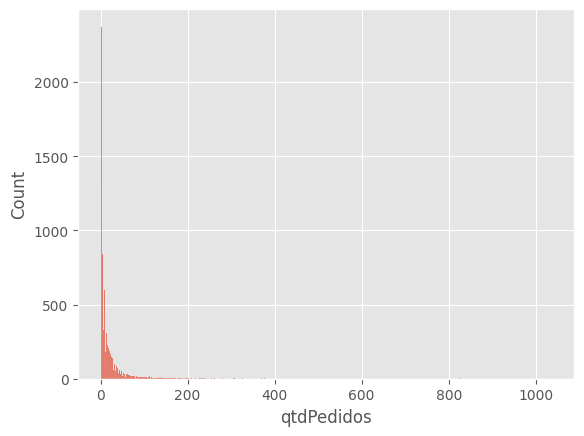

In [34]:
sns.histplot(df['qtdPedidos']);

Para obsevar melhor os dados, iremos realizar um corte no percentil 99 da quantidade de pedidos.

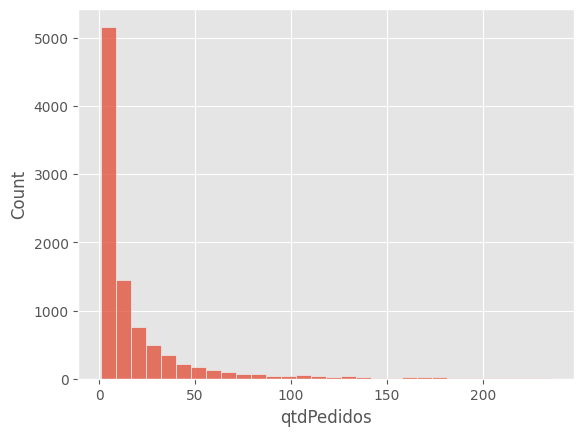

In [35]:
p99 = np.percentile(df['qtdPedidos'], 99)
sns.histplot(df['qtdPedidos'][df['qtdPedidos'] < p99], bins=30);

Podemos olhar mais a fundo ainda os vendedores que tiveram entre 1 a 50 pedidos:

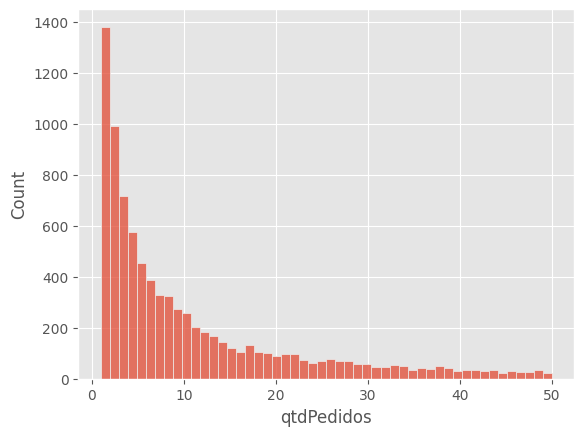

In [36]:
sns.histplot(df['qtdPedidos'][df['qtdPedidos'] <= 50], bins=50);

Pode-se observar que a proporção de vendedores que realizaram apenas de 1 a 5 pedidos é grande. Podemos observar se isso possui alguma relação com nossa target.

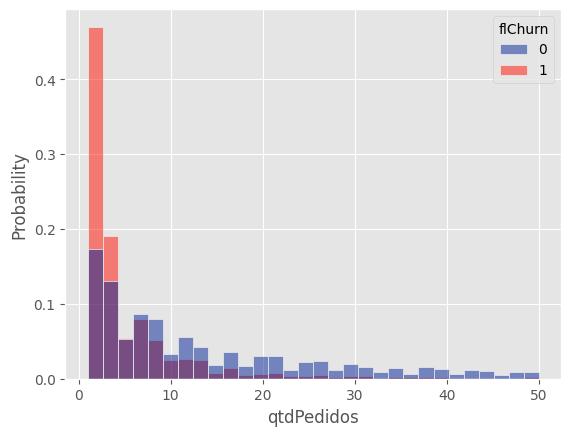

In [93]:
sns.histplot(x="qtdPedidos", hue="flChurn", bins=30,
             stat="probability", data=df[df["qtdPedidos"] <= 50],
             common_norm=False);

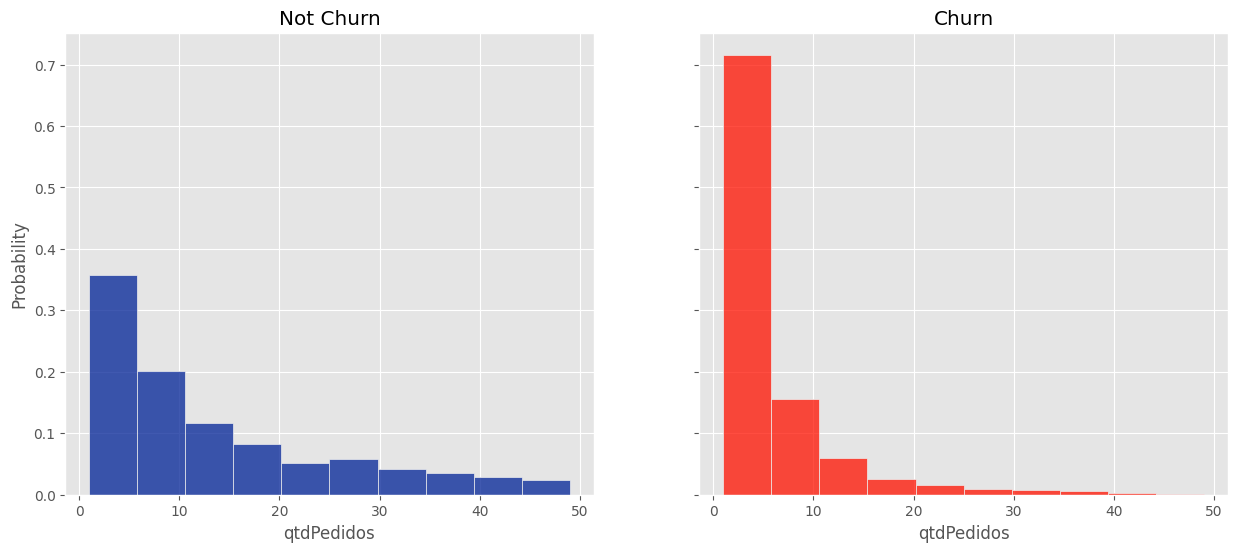

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.histplot(x='qtdPedidos', data=df[(df["flChurn"] == 0) & (df['qtdPedidos'] < 50)],
             stat="probability", bins= 10, color = palette[0],ax=ax1)
sns.histplot(x='qtdPedidos', data=df[(df["flChurn"] == 1) & (df['qtdPedidos'] < 50)],
             stat="probability", bins=10, color= palette[1], ax=ax2)
ax1.set_title("Not Churn")
ax2.set_title("Churn");

Temos um padrão na quantidade de vendas com o churning. Podemos observar que a probabilidade de um vendedor Churn ter entre 0 a 5 vendas é de 0.7, enquanto para um vendedor não churn, a probabilidade dele ter de 0 a 5 vendas é em torno de 0.35.

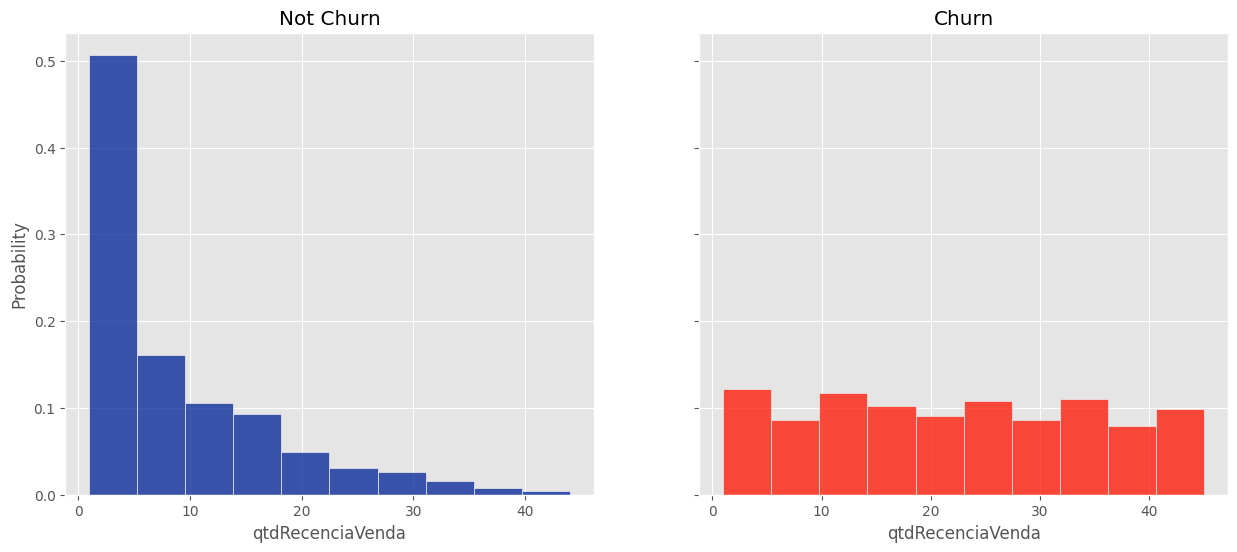

In [102]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.histplot(x='qtdRecenciaVenda', data=df[(df["flChurn"] == 0) & (df['qtdRecenciaVenda'] < 50)],
             stat="probability", bins= 10, color = palette[0],ax=ax1)
sns.histplot(x='qtdRecenciaVenda', data=df[(df["flChurn"] == 1) & (df['qtdRecenciaVenda'] < 50)],
             stat="probability", bins=10, color= palette[1], ax=ax2)
ax1.set_title("Not Churn")
ax2.set_title("Churn");

# Data Splitting

In [5]:
df['dtReference'].value_counts()

2018-01-01    1068
2017-12-01    1051
2018-02-01    1047
2017-11-01     875
2017-10-01     844
2017-09-01     779
2017-08-01     680
2017-06-01     652
2017-07-01     642
2017-05-01     580
2017-04-01     568
2017-03-01     481
2017-02-01     227
2017-01-01       1
Name: dtReference, dtype: int64

In [6]:
# creating an out of time sample

df_oot = df[df['dtReference'] == '2018-02-01']

df_train = df[df['dtReference'] != '2018-02-01']

In [7]:
df_train.shape, df_oot.shape

((8448, 95), (1047, 95))

In [8]:
var_identity = ['dtReference', 'idVendedor']
target = ['flChurn']
to_remove = ['qtdRecenciaVenda'] + target + var_identity

features = df.columns.tolist()
features = list(set(features) - set(to_remove))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], df_train[target].values.ravel(), test_size=0.2, random_state=23)

In [10]:
X_train.shape[0] + X_test.shape[0] + df_oot.shape[0]

9495

In [11]:
X_train.describe()

,minQtdParcelas,pct_valor_debit_card_pedido,pctCategoria_cama_mesa_banho,pctPedidoPE,pctCategoria_esporte_lazer,pctCategoria_beleza_saude,pctPedidoMS,qtdCategoriasVendedor,pctSalesOnTop15Category,pctPedidoPI,pctPedidoSP,qtde_credit_card_pedido,pctPedidoAP,qtdPedidos,pctPedidoMT,pctCategoria_eletronico,pct_valor_voucher_pedido,pctCategoria_perfumaria,pctPedidoES,pctCategoria_bebes,valor_credit_card_pedido,pct_qtd_boleto_pedido,pctCategoria_automotivo,avgFrete,avgProdutoPorPedido,avgIntervaloVendas,maxQtdParcelas,pctPedidoRN,pctPedidoAM,pct_qtd_voucher_pedido,avgPesoGramas,pctPedidoRS,avgDifDiasEntregaEstimativa,pctPedidosAtrasados,pctPedidoRR,qtdDiasComPedidos,pctCategoria_moveis_decoracao,pctCategoria_relogios_presentes,avgValorProduto,pctAvaliacao,valor_boleto_pedido,ticketMedio,pctCategoria_telefonia,pctPedidoMG,qtdUFsDistintos,avgVolProduto,avgNota,pctPedidoTO,pctPedidoSE,pctPedidoMA,valor_voucher_pedido,avgDifDiasEntregaAprovado,minValorProduto,pctPedidoAL,pct_qtd_debit_card_pedido,avgFotosVendedor,pctPedidoBA,maxVolProduto,qtde_debit_card_pedido,avgQtdParcelas,pctCategoria_brinquedos,maxNota,pctPedidoDF,pctPedidoCE,pctPedidoPA,pct_qtd_credit_card_pedido,qtde_boleto_pedido,maxValorProduto,minFrete,pctPedidoAC,pctPedidoRJ,pctCategoria_cool_stuff,pct_valor_boleto_pedido,qtde_voucher_pedido,pctCategoria_utilidades_domesticas,pctPedidoPR,pct_valor_credit_card_pedido,qtItens,maxFrete,pctPedidoCancelado,pctPedidoSC,lifeTimeValue,minVolProduto,minNota,pctCategoria_ferramentas_jardim,pctCategoria_informatica_acessorios,pctPedidoGO,pctPedidoRO,pctPedidoPB,qtdDiasPrimeiraVenda,valor_debit_card_pedido
count,6465.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.0,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,5671.000000,6465.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6619.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6757.000000,6751.000000,6758.000000,6758.000000,6758.000000,6758.000000,6757.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6757.000000,6758.000000,6465.000000,6758.000000,6751.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.00000,6758.000000,6758.000000,6758.000000,6758.000000,6757.000000,6751.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000,6758.000000
mean,1.963650,0.007710,0.041476,0.017339,0.100034,0.082939,0.006308,1.963747,0.706152,0.005539,0.382415,16.414324,0.000955,21.526191,0.010804,0.0,0.030186,0.026519,0.020046,0.027656,2624.681282,0.207551,0.048155,24.918814,1.059337,17.190985,7.410673,0.005056,0.002475,0.038437,2742.607974,0.060619,-12.566990,0.051053,0.000507,15.448210,0.089995,0.017724,161.911060,0.991115,654.376702,179.294121,0.026568,0.118172,5.631844,19449.271897,4.098298,0.003571,0.004989,0.007143,85.199700,13.486238,98.087854,0.006447,0.008829,2.258385,0.035796,35976.046026,0.197396,3.951045,0.040006,4.780033,0.023239,0.013706,0.011964,0.745183,4.544540,294.600872,15.475098,0.001451,0.139861,0.037828,0.207187,0.943030,0.066680,0.051864,0.754918,9.40293,49.889562,0.011062,0.037747,3219.548500,11068.693799,2.333136,0.041506,0.059068,0.021362,0.003589,0.007038,128.553862,20.235991
std,2.115568,0.040894,0.182118,0.070587,0.270761,0.250900,0.041259,1.829741,0.395082,0.045627,0.276067,38.078286,0.015335,49.825938,0.058210,0.0,0.083205,0.145441,0.074804,0.137255,6877.330529,0.226689,0.197476,19.925327,0.371631,21.687477,3.689543,0.035831,0.030513,0.084548,4371.175839,0.132045,9.945307,0.138425,0.010963,23.913976,0.255993,0.121516,267.431038,0.050125,1574.961540,299.586813,0.142582,0.180128,4.820809,28

# Pre Processing

In [12]:
X_train.isnull().sum().sort_values(ascending=False)

avgIntervaloVendas                 1087
minQtdParcelas                      293
avgQtdParcelas                      293
maxQtdParcelas                      293
pctPedidosAtrasados                 139
                                   ... 
pctCategoria_relogios_presentes       0
pctCategoria_moveis_decoracao         0
qtdDiasComPedidos                     0
pctPedidoRR                           0
valor_debit_card_pedido               0
Length: 91, dtype: int64

In [13]:
missing_minus_1 = ['avgIntervaloVendas', 'pctPedidosAtrasados', 'maxNota', 'avgNota',
                   'minNota', 'minVolProduto', 'maxVolProduto', 'avgDifDiasEntregaAprovado', 'avgVolProduto']

missing_zero = ['maxQtdParcelas', 'minQtdParcelas', 'avgQtdParcelas']

In [14]:
imputer_minus_1 = imputation.ArbitraryNumberImputer(arbitrary_number=-1,
                                                    variables=missing_minus_1)

imputer_zero = imputation.ArbitraryNumberImputer(arbitrary_number=0,
                                                 variables=missing_zero)

# Modeling

In [15]:
mlflow.set_experiment(experiment_name='olist_churn_prediction')
mlflow.sklearn.autolog()

In [20]:
with mlflow.start_run(run_name='random_forest_04'):

    model = RandomForestClassifier(max_depth=9,
                                   random_state=0)

    pipeline = Pipeline([
                        ('imputation_minus_1', imputer_minus_1),
                        ('imputation_0', imputer_zero),
                        ('model', model)
                        ])

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    y_train_score = pipeline.predict_proba(X_train)[:, 1]
    y_test_score = pipeline.predict_proba(X_test)[:, 1]
    
    #train metrics
    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    train_precision = metrics.precision_score(y_train, y_train_pred)
    train_recall = metrics.recall_score(y_train, y_train_pred)
    train_f1_score = metrics.f1_score(y_train, y_train_pred)
    train_auc = metrics.roc_auc_score(y_train, y_train_score)
    
    #test metrics
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    test_precision = metrics.precision_score(y_test, y_test_pred)
    test_recall = metrics.recall_score(y_test, y_test_pred)
    test_f1_score = metrics.f1_score(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_score)
    
    model_metrics = {"accuracy_train": train_accuracy,
                    "accuracy_test": test_accuracy,
                    "precision_train": train_precision,
                    "precision_test": test_precision,
                    "recall_train": train_recall,
                    "recall_test": test_recall,
                    "f1_score_train": train_f1_score,
                    "f1_score_test": test_f1_score,
                    "auc_train": train_auc,
                    "auc_test": test_auc}
    
    mlflow.log_metrics(model_metrics)
    mlflow.sklearn.log_model(model, "default random forest")

2023/10/04 19:54:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('imputation_minus_1', ArbitraryNumberImputer(arbitrary_number=-1,
                       variables=['avgIntervaloVendas', 'pctPedidosAtrasados',
                                  'maxNota', 'avgNota', 'minNota',
                                  'minVolProduto', 'maxVolProduto',
                                  'avgDifDiasEntregaAprovado',
                                  'avgVolProduto'])), ('imputation_0', ArbitraryNumberImputer(arbitrary_number=0,
                       variables=['max...`
